In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud




nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\thano\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thano\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'C:\Users\thano\Downloads\archive (4)\sentimentdataset.csv')

# Show basic structure
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [56]:
print(df.columns)


Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')


In [3]:
df.info()
df['Sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


Sentiment
 Positive           44
 Joy                42
 Excitement         32
 Neutral            14
 Contentment        14
                    ..
 Adrenaline          1
 Harmony             1
 ArtisticBurst       1
 Radiance            1
 Elegance            1
Name: count, Length: 279, dtype: int64

In [30]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,Text,object,0,0.000000
1,Sentiment,object,0,0.000000
2,Clean_Text,object,0,0.000000
3,Polarity,object,497,0.701977


In [4]:
df = df[['Text', 'Sentiment']]  # Keeping only the important columns
df = df[df['Sentiment'].str.strip() != '']  # Remove empty sentiment labels
df = df.drop_duplicates()
df['Sentiment'] = df['Sentiment'].str.strip().str.title()  # Standardize text

import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#\w+', '', text)     # remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # remove special chars
    return text.lower().strip()

df['Clean_Text'] = df['Text'].apply(clean_text)

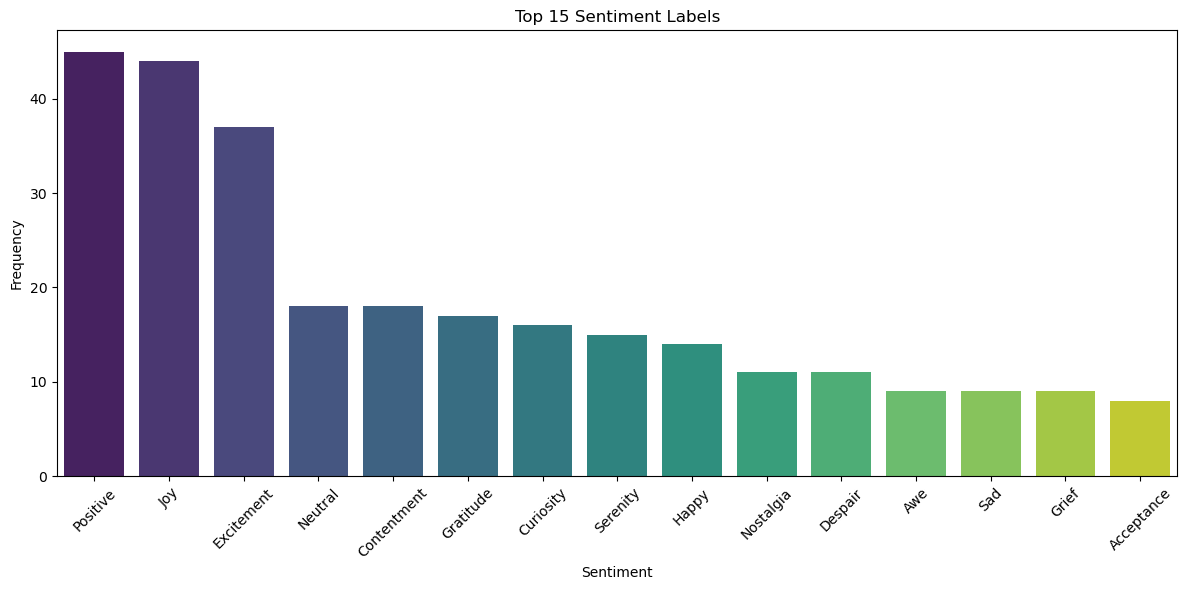

In [5]:
#Plot sentiment freuqencies
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 sentiments only (because we have too many!)
top_sentiments = df['Sentiment'].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_sentiments.index, y=top_sentiments.values, palette='viridis')
plt.title('Top 15 Sentiment Labels')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()

In [6]:
# Define lists of positive and negative sentiments (adjust as needed)
positive_sentiments = ['Positive', 'Joy', 'Excitement', 'Contentment', 'Happy', 'Love', 'Gratitude', 'Optimism', 'Relief']
negative_sentiments = ['Negative', 'Anger', 'Sadness', 'Fear', 'Anxiety', 'Disgust', 'Frustration', 'Loneliness', 'Guilt']

# Create a new column 'Polarity' based on these lists
def polarity_map(sentiment):
    if sentiment in positive_sentiments:
        return 'Positive'
    elif sentiment in negative_sentiments:
        return 'Negative'
    else:
        return None  # ignore neutral or unknown sentiments

df['Polarity'] = df['Sentiment'].apply(polarity_map)

# Drop rows with None polarity (neutral or unknown)
df_binary = df.dropna(subset=['Polarity'])

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df_binary['Clean_Text'])

le = LabelEncoder()
y = le.fit_transform(df_binary['Polarity'])  # Positive=1, Negative=0 (or vice versa)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Random Forest Accuracy: 0.8372093023255814
              precision    recall  f1-score   support

    Negative       1.00      0.12      0.22         8
    Positive       0.83      1.00      0.91        35

    accuracy                           0.84        43
   macro avg       0.92      0.56      0.57        43
weighted avg       0.86      0.84      0.78        43



In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd


In [11]:
# Import models and metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Store results
results = []

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(kernel='linear'),
    'Naive Bayes': MultinomialNB()
}

# Train, predict and evaluate each
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Negative)': report['Negative']['precision'],
        'Recall (Negative)': report['Negative']['recall'],
        'F1-Score (Negative)': report['Negative']['f1-score'],
        'Precision (Positive)': report['Positive']['precision'],
        'Recall (Positive)': report['Positive']['recall'],
        'F1-Score (Positive)': report['Positive']['f1-score']
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df)


C:\Users\thano\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\thano\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\thano\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\thano\anaconda3\Lib\site-packag

                    Model  Accuracy  Precision (Negative)  Recall (Negative)  \
0           Random Forest  0.837209                   1.0              0.125   
1     Logistic Regression  0.813953                   0.0              0.000   
2  Support Vector Machine  0.837209                   1.0              0.125   
3             Naive Bayes  0.813953                   0.0              0.000   

   F1-Score (Negative)  Precision (Positive)  Recall (Positive)  \
0             0.222222              0.833333                1.0   
1             0.000000              0.813953                1.0   
2             0.222222              0.833333                1.0   
3             0.000000              0.813953                1.0   

   F1-Score (Positive)  
0             0.909091  
1             0.897436  
2             0.909091  
3             0.897436  


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


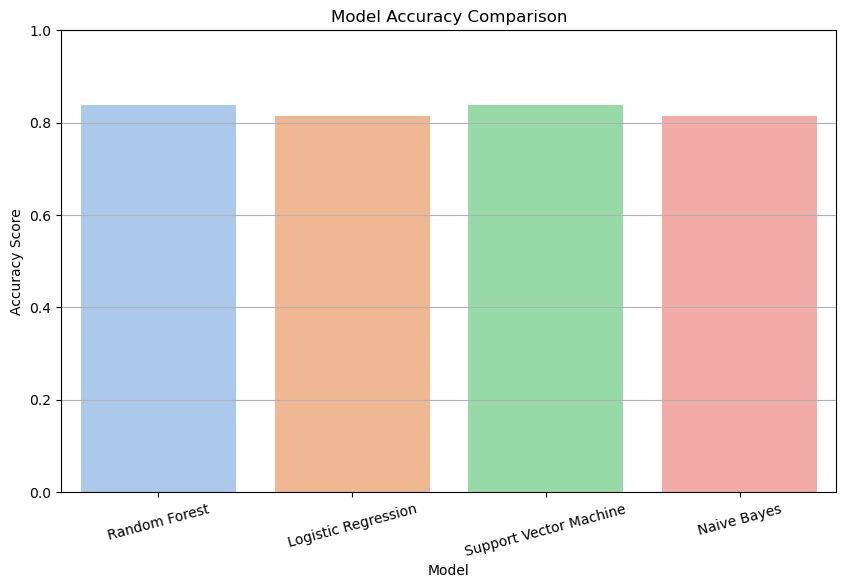

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='pastel')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy Score')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()


In [20]:
# Convert wide format to long format for easier plotting
melted_metrics = results_df.melt(id_vars='Model', 
    value_vars=[
        'Precision (Negative)', 'Recall (Negative)', 'F1-Score (Negative)',
        'Precision (Positive)', 'Recall (Positive)', 'F1-Score (Positive)'
    ],
    var_name='Metric', value_name='Score'
)

# Split the 'Metric' column into two: Metric Type and Class
melted_metrics[['Metric Type', 'Class']] = melted_metrics['Metric'].str.extract(r'(\w+)-Score \((\w+)\)')


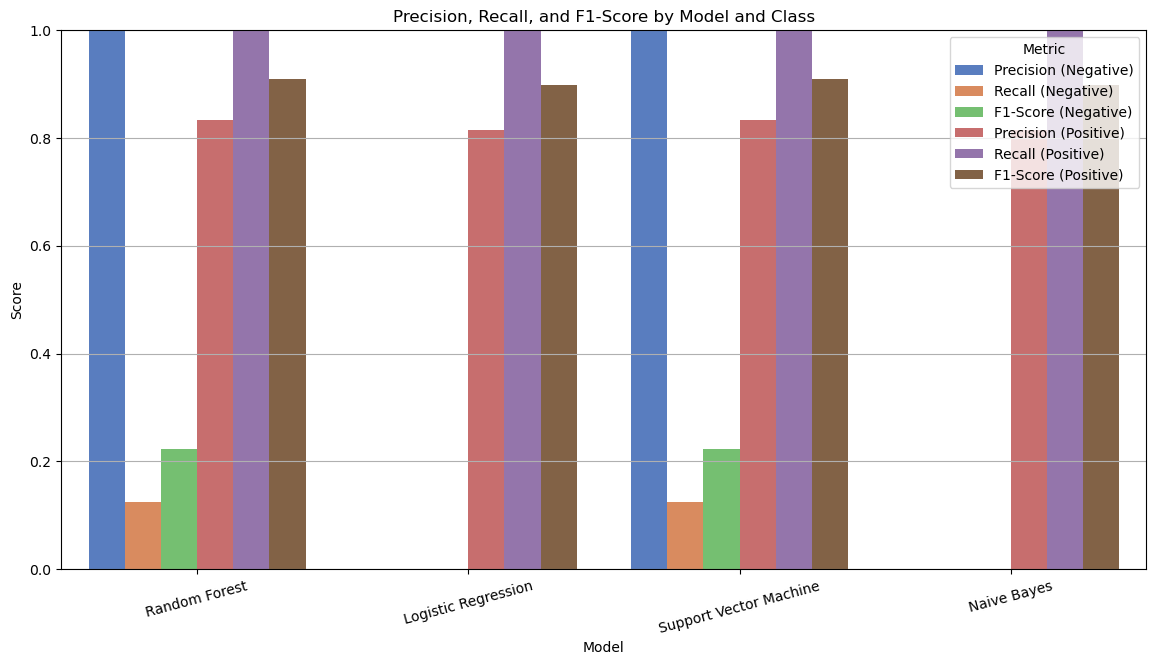

In [23]:
plt.figure(figsize=(14, 7))
sns.barplot(data=melted_metrics, x='Model', y='Score', hue='Metric', palette='muted')
plt.title('Precision, Recall, and F1-Score by Model and Class')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.legend(title='Metric')
plt.grid(axis='y')
plt.show()


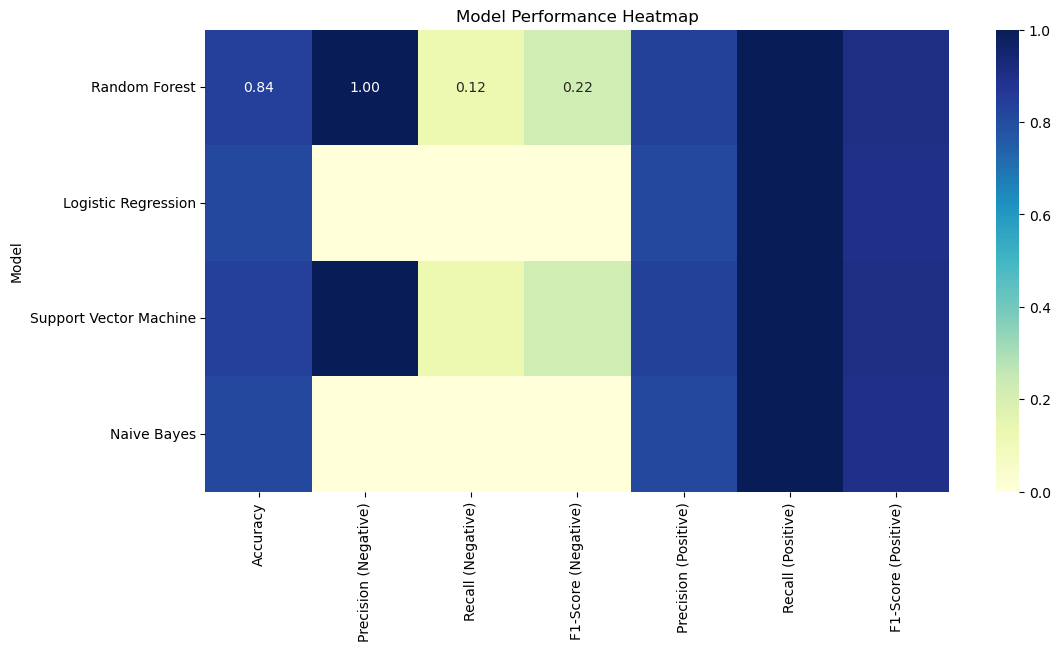

In [21]:
# Set Model as index and remove it from columns
heatmap_df = results_df.set_index('Model')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Model Performance Heatmap')
plt.show()


<Figure size 600x400 with 0 Axes>

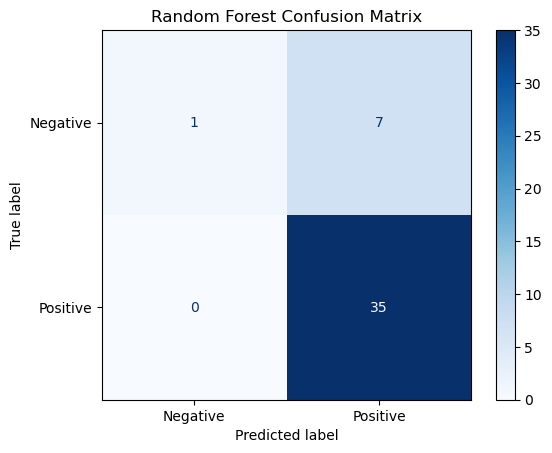

<Figure size 600x400 with 0 Axes>

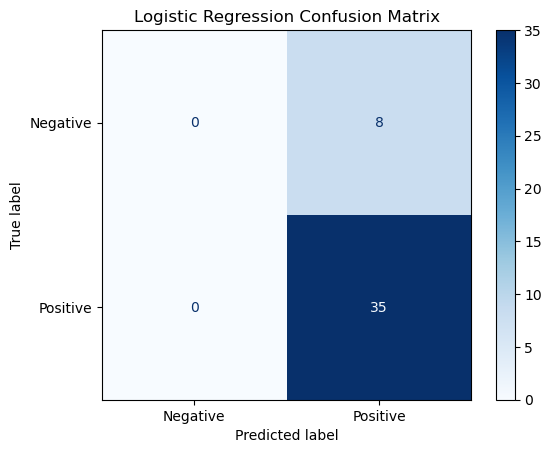

<Figure size 600x400 with 0 Axes>

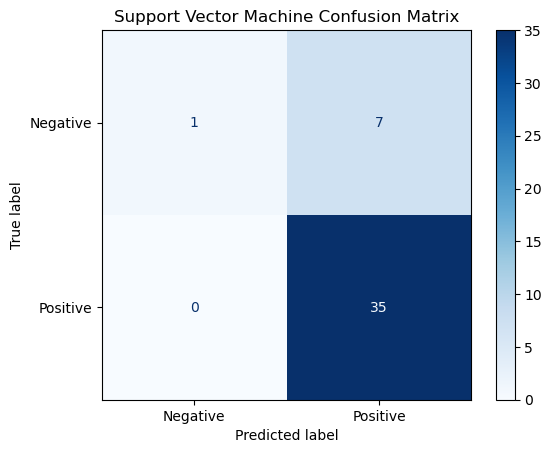

<Figure size 600x400 with 0 Axes>

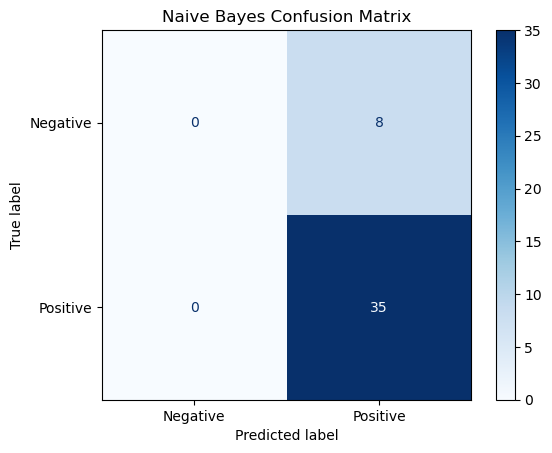

In [25]:
  import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define models again (if not already defined)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(kernel='linear'),
    'Naive Bayes': MultinomialNB()
}

# Plot confusion matrix for each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    
    plt.figure(figsize=(6, 4))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.grid(False)
    plt.show()


In [26]:
# We need to get the test set indices from the train_test_split to align texts correctly
# When you did train_test_split, you can do it like this to keep track of indices:

from sklearn.model_selection import train_test_split

# Assuming your df_binary['Clean_Text'] and y are defined

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, df_binary.index, test_size=0.2, random_state=42
)

# After prediction, use test_idx to get the texts
results_df = pd.DataFrame({
    'Text': df_binary.loc[test_idx, 'Clean_Text'].values,
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(y_pred)
})

results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

print("First 10 predictions (misclassifications marked):\n")
print(results_df.head(10))

print("\nMisclassified samples:\n")
print(results_df[~results_df['Correct']].head(10))

First 10 predictions (misclassifications marked):

                                                Text    Actual Predicted  \
0                winter sports day at the local park  Positive  Positive   
1  bonding with friends over the latest kpop sens...  Positive  Positive   
2  sipping on a favorite vintage wine each sip te...  Positive  Positive   
3      disgust at the sight of injustice and cruelty  Negative  Positive   
4  sending love to all my followers on this beaut...  Positive  Positive   
5  successfully fundraising for a school charity ...  Positive  Positive   
6            feeling optimistic about the week ahead  Positive  Positive   
7  planning a surprise scavenger hunt for friends...  Positive  Positive   
8              feeling a bit under the weather today  Negative  Positive   
9  in the garden of contentment each bloom whispe...  Positive  Positive   

   Correct  
0     True  
1     True  
2     True  
3    False  
4     True  
5     True  
6     True  
7     Tr

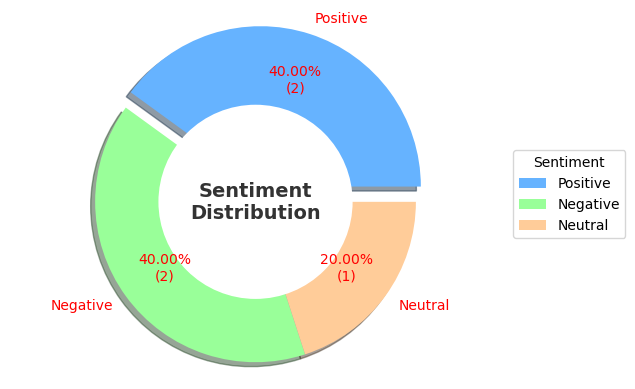

In [32]:
# Example DataFrame
data = {'Sentiment': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative']}
df1 = pd.DataFrame(data)

# Pie chart parameters
colors = ['#66b3ff', '#99ff99', '#ffcc99']
explode = (0.1, 0, 0)  # Adjust length based on unique Sentiments

# Grouping data
sentiment_counts = df1['Sentiment'].value_counts()

# Plot
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    x=sentiment_counts.values,  # Pass values
    labels=sentiment_counts.index,  # Pass labels
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),
    pctdistance=0.7,
    colors=colors[:len(sentiment_counts)],  # Ensure matching colors
    explode=explode[:len(sentiment_counts)],  # Ensure matching explode
    shadow=True
)

# Add center circle
center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

# Add central text
ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

# Add legend
ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  # Equal aspect ratio
plt.show()

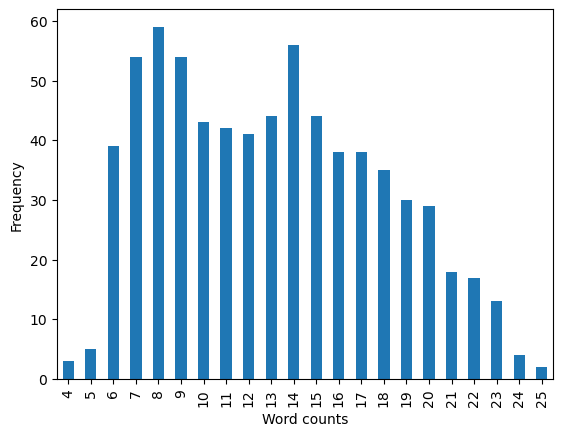

In [36]:
# word count for each comments
word_length = df['Text'].apply(lambda comment: len(comment.split()))
length_summary = word_length.value_counts().sort_index()
length_summary.plot(kind='bar')
plt.xlabel('Word counts')
plt.ylabel('Frequency')
plt.show()

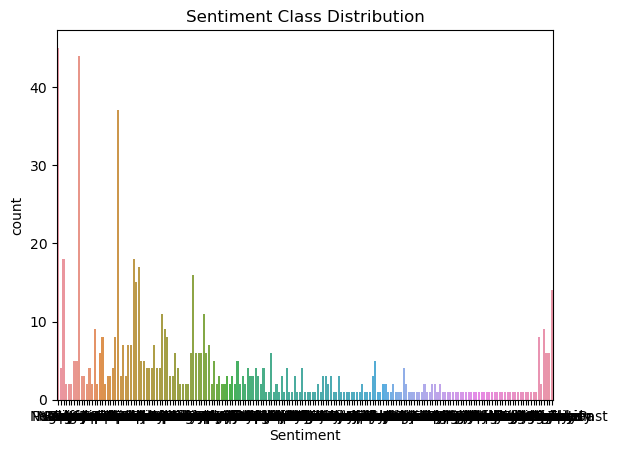

In [39]:
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Class Distribution')
plt.show()


In [38]:
print(df.columns)


Index(['Text', 'Sentiment', 'Clean_Text', 'Polarity'], dtype='object')


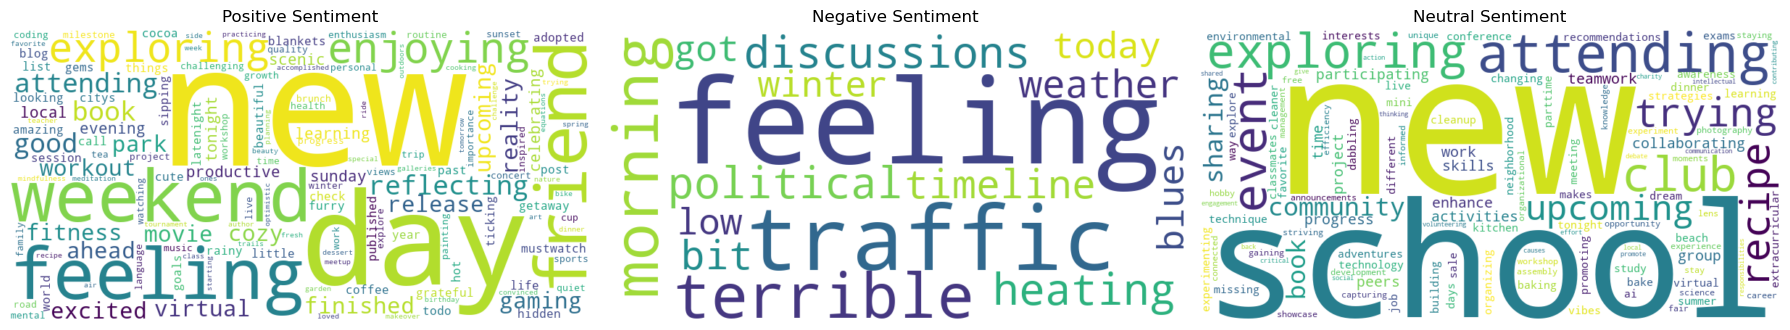

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert all clean text to lowercase
df['Clean_Text'] = df['Clean_Text'].str.lower()

# Positive
text_positive = " ".join(df[df['Sentiment'] == 'Positive']['Clean_Text'].dropna())
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(text_positive)

# Negative
text_negative = " ".join(df[df['Sentiment'] == 'Negative']['Clean_Text'].dropna())
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(text_negative)

# Neutral
text_neutral = " ".join(df[df['Sentiment'] == 'Neutral']['Clean_Text'].dropna())
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(text_neutral)

# Plotting
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Sentiment")

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Sentiment")

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.title("Neutral Sentiment")

plt.tight_layout()
plt.show()


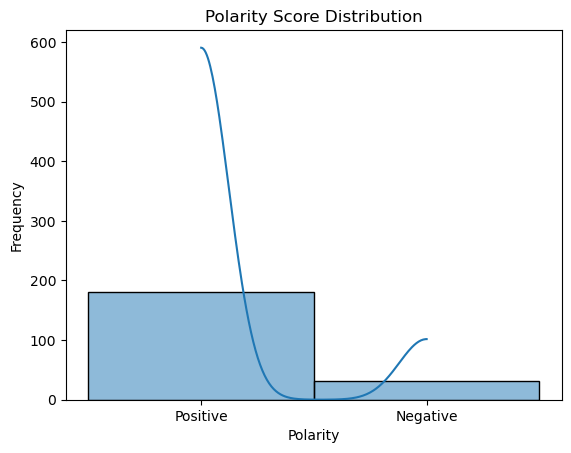

In [48]:
sns.histplot(data=df, x='Polarity', bins=30, kde=True)
plt.title("Polarity Score Distribution")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()


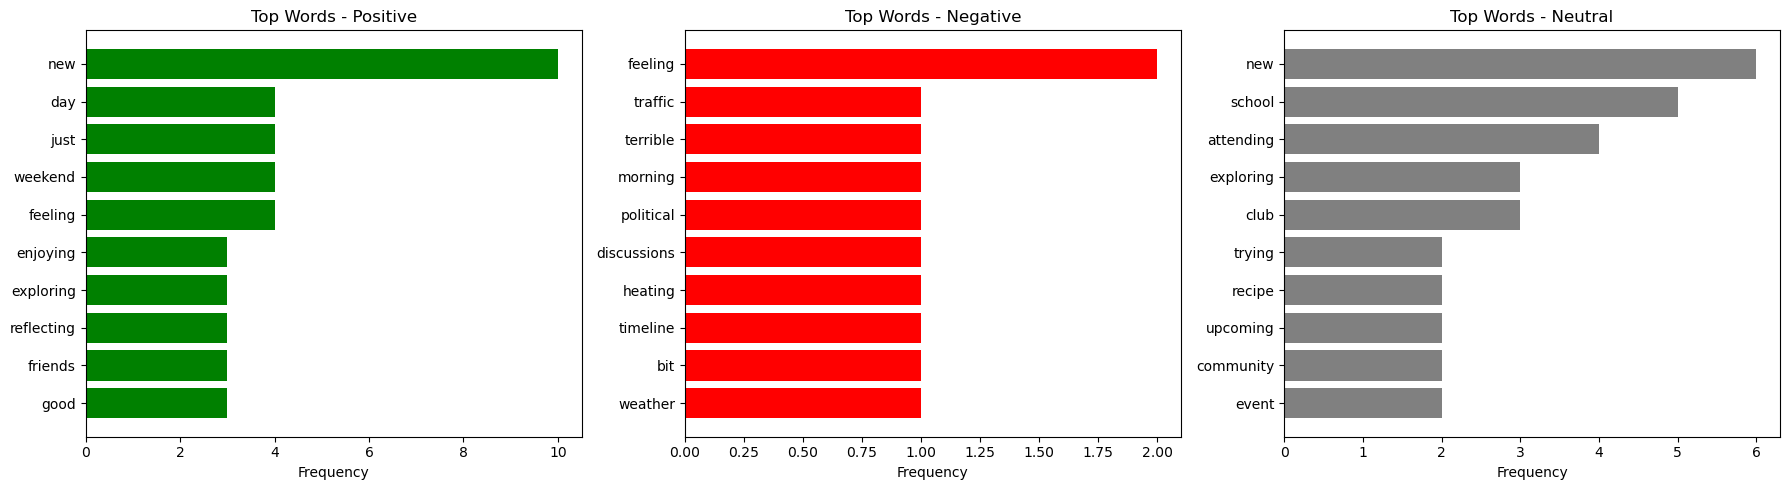

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Make sure text is lowercase and clean
df['Clean_Text'] = df['Clean_Text'].str.lower()

# Function to get top N words per sentiment
def get_top_n_words(texts, n=10):
    vec = CountVectorizer(stop_words='english')
    bag_of_words = vec.fit_transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return word_freq[:n]

# Get top words per sentiment
top_positive = get_top_n_words(df[df['Sentiment'] == 'Positive']['Clean_Text'], n=10)
top_negative = get_top_n_words(df[df['Sentiment'] == 'Negative']['Clean_Text'], n=10)
top_neutral = get_top_n_words(df[df['Sentiment'] == 'Neutral']['Clean_Text'], n=10)

# Plotting function
def plot_top_words(word_freq, title, color):
    words, freqs = zip(*word_freq)
    plt.barh(words, freqs, color=color)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Frequency")

# Plot all three
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plot_top_words(top_positive, "Top Words - Positive", "green")

plt.subplot(1, 3, 2)
plot_top_words(top_negative, "Top Words - Negative", "red")

plt.subplot(1, 3, 3)
plot_top_words(top_neutral, "Top Words - Neutral", "gray")

plt.tight_layout()
plt.show()


In [49]:
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text


In [52]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\thano


In [57]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import re

DATASET_PATH = r'C:\Users\thano\Downloads\archive (4)\sentimentdataset.csv'

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

try:
    df = pd.read_csv(DATASET_PATH)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

TEXT_COL = 'Text'
SENTIMENT_COL = 'Sentiment'

df['cleaned_text'] = df[TEXT_COL].apply(preprocess_text)

X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df[SENTIMENT_COL], test_size=0.2, random_state=42)

tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)

def analyze_sentiment():
    user_input = entry.get()
    if not user_input.strip():
        messagebox.showwarning("Input Error", "Please enter some text.")
        return
    
    cleaned_input = preprocess_text(user_input)
    input_vec = tfidf.transform([cleaned_input])
    prediction = rf_model.predict(input_vec)[0]
    
    color_map = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'orange'}
    result_label.config(text=f"Predicted Sentiment: {prediction}", fg=color_map.get(prediction, 'black'))

root = tk.Tk()
root.title("Sentiment Analysis Tool")
root.geometry("500x300")
root.config(bg="#e6f0ff")

frame = tk.Frame(root, bg="#e6f0ff", padx=20, pady=20)
frame.pack(expand=True)

title_label = tk.Label(frame, text="Sentiment Analysis Tool", font=("Helvetica", 20, "bold"), bg="#e6f0ff", fg="#004080")
title_label.pack(pady=(0, 15))

prompt_label = tk.Label(frame, text="Enter a sentence:", font=("Helvetica", 14), bg="#e6f0ff")
prompt_label.pack(anchor='w')

entry = tk.Entry(frame, width=50, font=("Helvetica", 14), relief='groove', bd=3)
entry.pack(pady=10)

analyze_button = tk.Button(frame, text="Analyze Sentiment", command=analyze_sentiment,
                           font=("Helvetica", 14, "bold"), bg="#0059b3", fg="white", activebackground="#004080", relief="raised", bd=4)
analyze_button.pack(pady=10)

result_label = tk.Label(frame, text="", font=("Helvetica", 16, "bold"), bg="#e6f0ff")
result_label.pack(pady=20)

root.mainloop()
